In [11]:
crypto = 'IOTA'

# Install and import necessary libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%%capture
!pip install emoji

In [5]:
%%capture
!pip install contractions

In [6]:
%%capture
!pip install transformers

In [7]:
%%capture
pip install pysentimiento

In [8]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re, string
import emoji
import contractions

import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax
import torch
from datetime import datetime as dt
import sys
import gc


# Load twitter data from Google Drive into Google Colab

In [15]:
## Due to the limitation of CSV files in terms of number of records, we have saved our data into two files
## We import two CSV files and concatenate them into one single DataFrame
os.chdir('/content/drive/MyDrive/Research/Price/twitter_data')
DF1 = pd.read_csv(crypto+'_tweets_2021_1.csv')
DF2 = pd.read_csv(crypto+'_tweets_2021_2.csv')
DF = pd.concat([DF1, DF2], axis = 0)
DF.index = range(len(DF))
DF['ID'] = DF['url'].str[-19:]
print(len(DF1), len(DF2), len(DF))

DF.head()


233174 199433 432607


,Unnamed: 0,datetime,text,like count,reply count,retweet count,tweet Id,username,url,outlink,ID
0,0,2021-01-01 23:58:24+00:00,@CawthornforNC so now we know you are anti-Dem...,0,0,0,1345157456431874048,mbadboy10,https://twitter.com/mbadboy10/status/134515745...,NaN,1345157456431874048
1,1,2021-01-01 23:55:08+00:00,"@McKayMSmith yeah, I don't feel one iota of co...",1,0,0,1345156636667740160,YatPundit,https://twitter.com/YatPundit/status/134515663...,NaN,1345156636667740160
2,2,2021-01-01 23:54:12+00:00,@LonelyBeats3 Are your family and friends list...,1,1,0,1345156400767492096,iotabuddy,https://twitter.com/iotabuddy/status/134515640...,NaN,1345156400767492096
3,3,2021-01-01 23:46:59+00:00,@gruppe5 @accretionist @bleya1910 the wise wil...,1,0,0,1345154585611132936,AzanyahM,https://twitter.com/AzanyahM/status/1345154585...,NaN,1345154585611132936
4,4,2021-01-01 23:44:22+00:00,People that have no iota of remorse when they ...,1,0,0,1345153925108928514,Ummi_Hayat,https://twitter.com/Ummi_Hayat/status/13451539...,NaN,1345153925108928514


# Data preprocessing

In [16]:
DF.isnull().sum()

Unnamed: 0            0
datetime              0
text                  0
like count            0
reply count           0
retweet count         0
tweet Id              0
username              0
url                   0
outlink          367263
ID                    0
dtype: int64

## Prepocessing

In [17]:
## The only punctuations that we will remove is "=" and "==" and this is because they create problems when importing/exporting data into excel/CSV files
## The other punctuations are usefull for our sentiment analysis purposes

punct = ['=', '==']
def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text



def expand(text):
  '''
  To expand contraction words, for example: "can't" --> "can not"
  '''
  expanded_words = []
  for word in text.split():
    expanded_words.append(contractions.fix(word))

  expanded_text = ' '.join(expanded_words)
  return expanded_text


def ReplaceThreeOrMore(text):
    '''
    pattern to look for three or more repetitions of any character, including newlines.
    '''
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
    return pattern.sub(r"\1\1", text)

##  the stop words list contains some words that could be important in some contexts.
   ## We will not remove them from the texts.
   ## one another alternative way is to customize the stop words list for our applications (not included in this notebook)


In [18]:
def clean(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()  # remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # remove links and mentions
    text = re.sub(r'[$][A-Za-z][\S]*', "", text)  # remove ticker symbols ($)
    text = re.sub(r'#', '', text) # remove hashtag symbols (#)
    text = emoji.demojize(text) # replace any emojis with the text they represent rather than removing them
    text = expand(text)
    text = remove_punctuations(text)
    text = ReplaceThreeOrMore(text)
    text = ' '.join( [w for w in text.split() if len(w)>1] ) # remove words with 1 character
    text = re.sub(r'\w*\d\w*', '', text).strip() # remove words that contain number
    text = re.sub("\s\s+" , " ", text)  # remove multiple spaces
    return text


tweet_example = "😳 Tom .....Braaaaaady g bay's Bullish on Bitcoin &amp;     Cathie Wood of Ark Invest Applies For Bitcoin ETF LOL you're - June 30th 2021 https://t.co/0lpxVB3P0A via @YouTube @bitcoin #Bitcoin #BTC $BTC 🐦"
clean(tweet_example)



":flushed_face: tom ..braady bay's bullish on bitcoin &amp; cathie wood of ark invest applies for bitcoin etf lol you are june via bitcoin btc :bird:"

In [19]:
## Clean all texts
DF["cleaned_tweet"] = DF['text'].apply(lambda text: clean(text))

In [20]:
DF.columns

Index(['Unnamed: 0', 'datetime', 'text', 'like count', 'reply count',
       'retweet count', 'tweet Id', 'username', 'url', 'outlink', 'ID',
       'cleaned_tweet'],
      dtype='object')

In [21]:
DF = DF.drop(columns=['Unnamed: 0', 'like count', 'reply count',
       'retweet count', 'tweet Id', 'username', 'url', 'outlink',
       ])
pd.set_option("max_colwidth", 256)
DF.head()

,datetime,text,ID,cleaned_tweet
0,2021-01-01 23:58:24+00:00,@CawthornforNC so now we know you are anti-Democracy. Please show me one iota of proof. America will not forget.,1345157456431874048,so now we know you are anti-democracy. please show me one iota of proof. america will not forget.
1,2021-01-01 23:55:08+00:00,"@McKayMSmith yeah, I don't feel one iota of concern when a kluxer tries the you're-not-Jewish line.",1345156636667740160,"yeah, do not feel one iota of concern when kluxer tries the you are-not-jewish line."
2,2021-01-01 23:54:12+00:00,@LonelyBeats3 Are your family and friends listening to you this time about #IOTA? It'd be a shame for them to miss the boat twice. 😌,1345156400767492096,are your family and friends listening to you this time about iota? it would be shame for them to miss the boat twice. :relieved_face:
3,2021-01-01 23:46:59+00:00,"@gruppe5 @accretionist @bleya1910 the wise will acquire, accumulate and HODL! #IOTA",1345154585611132936,"the wise will acquire, accumulate and hodl! iota"
4,2021-01-01 23:44:22+00:00,"People that have no iota of remorse when they intentionally hurt you can kill you and still feel it is their right to, may Allah protect us from those type of people.",1345153925108928514,"people that have no iota of remorse when they intentionally hurt you can kill you and still feel it is their right to, may allah protect us from those type of people."


In [22]:
print(len(DF))
print(len(DF[DF['cleaned_tweet'].str.len() < 3]))
drop_indices = list(DF[DF['cleaned_tweet'].str.len() < 3].index) # Remove strings with less than 4 words
drop_indices
DF.drop(drop_indices,axis=0, inplace=True)
print(len(DF))

432607
371
432236


In [24]:
def isNaN(string):
    return string != string
DF.dropna(inplace=True)
print(len(DF))

432236


In [ ]:
# os.chdir("/content/drive/My Drive/Research/twitter_data")
# # DF.to_excel('xx_preprocessed.xlsx')
# # DF.to_excel(crypto+'_preprocessed.xlsx')

# int(len(DF)/2)
# preprocessed_1 = DF[:int(len(DF)/2)]
# preprocessed_2 = DF[int(len(DF)/2):]
# print(len(preprocessed_1), len(preprocessed_2))
# preprocessed_1.to_excel(crypto+'_preprocessed_1.xlsx')
# preprocessed_2.to_excel(crypto+'_preprocessed_2.xlsx')


In [ ]:
# os.chdir('/content/drive/MyDrive')
# DF = pd.read_excel('xx_preprocessed.xlsx')
# print(len(DF))
# DF.head()

# Sentiment Analysis:
* FinBERT: [Source code 1](https://colab.research.google.com/drive/1jEHhU5_x4oQkelW3p__fY2y0m3-z7Y5P?usp=sharing), [Source code 2](https://github.com/Raviraj2000/Financial-News-Sentiment-Analysis-using-FinBERT/blob/main/SentimentAnalysis.ipynb)
* Twitter-roBERTa-base for Sentiment Analysis - UPDATED (2021): [Source](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)
* pysentimiento: [source](https://github.com/pysentimiento/pysentimiento)

In [25]:
DF_array = np.array(DF)
DF_list = list(DF_array[ : , -1])
print(len(DF_list))
# DF_list

432236


In [ ]:
# os.chdir("/content/drive/My Drive/Research/Price/sentiment_data/Majority_Sentiments")
# DF1 = pd.read_excel(crypto+'_Majority_Sentiments_1_new.xlsx')
# DF2 = pd.read_excel(crypto+'_Majority_Sentiments_2_new.xlsx')
# DF = pd.concat([DF1, DF2], axis = 0)
# print(len(DF_list), len(DF))
# print(len(DF_list)- len(DF))

In [26]:
list_tmp = list(range(int(len(DF_list)/100000)+1))
list_tmp

[0, 1, 2, 3, 4]

## Model 1

In [ ]:
# labels = {0:'neutral', 1:'positive',2:'negative'}
MODEL = f"ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


for i in range(int(len(DF_list)/100000)):
  if (i+1)*100000 < len(DF):
    end_index = (i+1)*100000
  else:
    end_index = len(DF)

  DF_list_tmp = DF_list[i*100000:end_index]
  predictions = []
  for tweet in DF_list_tmp:
      inputs = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True, max_length=512)
      outputs = model(**inputs)
      scores = outputs[0][0].detach().numpy()
      scores = softmax(scores)
      predictions.append(scores)
  model.config.id2label

  positive = [pred[0] for pred in predictions]
  negative = [pred[1] for pred in predictions]
  neutral = [pred[2] for pred in predictions]
  table = { 'datetime': DF.datetime[i*100000:end_index],
            'Tweet': DF.cleaned_tweet[i*100000:end_index],
            "Negative": negative,
            "Neutral": neutral,
            "Positive": positive
          }

  df_FinBERT_tmp = pd.DataFrame(table, columns = ["datetime", "Tweet",  "Negative", "Neutral", "Positive"])
  df_FinBERT_tmp['sentiment'] = df_FinBERT_tmp[["Negative", "Neutral", "Positive"]].idxmax(axis=1)
  df_FinBERT_tmp.to_excel(crypto + '_'+ str(i) + '_model_1' +'_sentiments.xlsx')

  print(i)


## Model 2

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)

for i in range(int(len(DF_list)/100000)):
  if (i+1)*100000 < len(DF):
    end_index = (i+1)*100000
  else:
    end_index = len(DF)

  DF_list_tmp = DF_list[i*100000:end_index]
  predictions = []
  for tweet in DF_list_tmp:
      inputs = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True, max_length=512)
      outputs = model(**inputs)
      scores = outputs[0][0].detach().numpy()
      scores = softmax(scores)
      predictions.append(scores)
  model.config.id2label

  negative = [pred[0] for pred in predictions]
  neutral = [pred[1] for pred in predictions]
  positive = [pred[2] for pred in predictions]
  table = { 'datetime': DF.datetime[i*100000:end_index],
            'Tweet': DF.cleaned_tweet[i*100000:end_index],
            "Negative": negative,
            "Neutral": neutral,
            "Positive": positive
          }

  df_roBERTa_tweet_tmp = pd.DataFrame(table, columns = ["datetime", "Tweet",  "Negative", "Neutral", "Positive"])
  df_roBERTa_tweet_tmp['sentiment'] = df_roBERTa_tweet_tmp[["Negative", "Neutral", "Positive"]].idxmax(axis=1)
  df_roBERTa_tweet_tmp.to_excel(crypto + '_'+ str(i) + '_model_2' +'_sentiments.xlsx')

  print(i)

## Model 3

In [ ]:
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="en")
MODEL = f"pysentimiento/robertuito-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

##   "id2label": {
  #   "0": "NEG",
  #   "1": "NEU",
  #   "2": "POS"
  # },


for i in list_tmp:
  if (i+1)*100000 < len(DF):
    end_index = (i+1)*100000
  else:
    end_index = len(DF)

  DF_list_tmp = DF_list[i*100000:end_index]
  predictions = []
  for tweet in DF_list_tmp:
      predicted = analyzer.predict(tweet)
      predictions.append([predicted.probas['NEG'], predicted.probas['NEU'], predicted.probas['POS'] ])
  # model.config.id2label

  negative = [pred[0] for pred in predictions]
  neutral = [pred[1] for pred in predictions]
  positive = [pred[2] for pred in predictions]
  table = { 'datetime': DF.datetime[i*100000:end_index],
            'Tweet': DF.cleaned_tweet[i*100000:end_index],
            "Negative": negative,
            "Neutral": neutral,
            "Positive": positive
          }

  df_pysentimiento_tmp = pd.DataFrame(table, columns = ["datetime", "Tweet",  "Negative", "Neutral", "Positive"])
  df_pysentimiento_tmp['sentiment'] = df_pysentimiento_tmp[["Negative", "Neutral", "Positive"]].idxmax(axis=1)
  df_pysentimiento_tmp.to_excel(crypto + '_'+ str(i) + '_model_3' +'_sentiments.xlsx')

  print(i)

loading configuration file https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/cb09766f7ba60b5f7a1bb640617b24f1499c4a6f3ab160c4a0ac171e3a377c68.008dca06003188334001a96363da79ced4944abc68d94a2f1e0db786dc5aa08b
Model config RobertaConfig {
  "_name_or_path": "finiteautomata/bertweet-base-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "n

2


# Majority vote: Keep the tweets that are given the same labels by at least two models

In [ ]:

os.chdir("/content/drive/My Drive/Research/Price/sentiment_data/Model3")

df_FinBERT = pd.DataFrame(columns=["datetime",	"Tweet",	"Negative",	"Neutral",	"Positive",	"sentiment"])
df_FinBERT
for i in range(len(list_tmp)):
  df_tmp = pd.read_excel(crypto + '_'+ str(i) + '_model_1' +'_sentiments.xlsx')
  df_FinBERT = pd.concat([df_FinBERT, df_tmp], axis = 0)
print(len(df_FinBERT))

df_roBERTa_tweet = pd.DataFrame(columns=["datetime",	"Tweet",	"Negative",	"Neutral",	"Positive",	"sentiment"])
for i in range(len(list_tmp)):
  df_tmp = pd.read_excel(crypto + '_'+ str(i) + '_model_2' +'_sentiments.xlsx')
  df_roBERTa_tweet = pd.concat([df_roBERTa_tweet, df_tmp], axis = 0)
print(len(df_roBERTa_tweet))

df_pysentimiento = pd.DataFrame(columns=["datetime",	"Tweet",	"Negative",	"Neutral",	"Positive",	"sentiment"])
for i in range(len(list_tmp)):
  df_tmp = pd.read_excel(crypto + '_'+ str(i) + '_model_3' +'_sentiments.xlsx')
  df_pysentimiento = pd.concat([df_pysentimiento, df_tmp], axis = 0)
print(len(df_pysentimiento))

432236
432236
432236


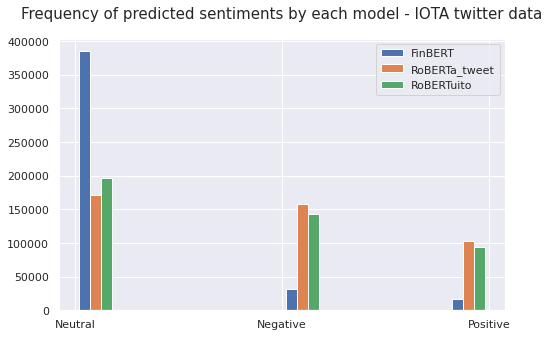

In [ ]:
os.chdir("/content/drive/My Drive/Research/Price/sentiment_data/Majority_Sentiments")

fig = plt.figure(figsize=(8,5))
plt.hist([df_FinBERT.sentiment.values.flatten(), df_roBERTa_tweet.sentiment.values.flatten(), df_pysentimiento.sentiment.values.flatten()], label=['FinBERT', 'RoBERTa_tweet', 'RoBERTuito'])
plt.legend()
plt.title("Frequency of predicted sentiments by each model" +' - ' + crypto + ' twitter data', fontsize = 15, pad=20)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

fig.savefig(crypto + '_sentiments_frequency_new.png')


In [ ]:

df_tmp = pd.DataFrame([], columns = ['datetime', 'tweet', 'sentiment1', 'sentiment2', 'sentiment3'])

df_tmp['datetime'] = df_FinBERT['datetime']
df_tmp['tweet'] = df_FinBERT['Tweet']
df_tmp['sentiment1'] = df_FinBERT['sentiment']
df_tmp['sentiment2'] = df_roBERTa_tweet['sentiment']
df_tmp['sentiment3'] = df_pysentimiento['sentiment']


# df_tmp['majority'] = df_tmp.mode(axis=1)


mode = df_tmp.mode(axis=1)
df_tmp['majority'] = np.where(mode.isna().any(1), mode[0], 'split')
df_tmp
len(df_tmp)

lost_df = df_tmp[df_tmp['majority'] == 'split']
lost_df
len(lost_df)

df_final = df_tmp[df_tmp['majority'] != 'split']

print('length of preprocessed tweets data: ' , len(df_tmp))
print('length of sentiment data after taking majority vote: ' , len(df_final))
print('length of lost data because of taking majority votes: ' , len(lost_df))


length of preprocessed tweets data:  432236
length of sentiment data after taking majority vote:  428595
length of lost data because of taking majority votes:  3641


In [ ]:
os.chdir("/content/drive/My Drive/Research/Price/sentiment_data/Majority_Sentiments")
int(len(df_final)/2)
maj_1 = df_final[:int(len(df_final)/2)]
maj_2 = df_final[int(len(df_final)/2):]
# maj_1 = pd.read_excel("Bitcoin_Majority_Sentiments_1.xlsx")
# maj_2 = pd.read_excel("Bitcoin_Majority_Sentiments_2.xlsx")
print(len(maj_1), len(maj_2))
maj_1.to_excel(crypto+'_Majority_Sentiments_1_new.xlsx')
maj_2.to_excel(crypto+'_Majority_Sentiments_2_new.xlsx')

214297 214298


## Aggregate sentiments (calculate sentiment scores)

In [ ]:

df_final['datetime'] = df_final['datetime'].apply(lambda datetime: dt.strptime(datetime,"%Y-%m-%d %H:%M:%S%z"))


df1 = df_final.copy()
df2 = df_final.copy()
df3 = df_final.copy()

df1['majority'] = df1['majority'].mask(df_final['majority'].ne('Negative'))
df_Negative_counts = df1.set_index('datetime').groupby(pd.Grouper(freq='D')).count()


df2['majority'] = df2['majority'].mask(df_final['majority'].ne('Neutral'))
df_Neutral_counts = df2.set_index('datetime').groupby(pd.Grouper(freq='D')).count()


df3['majority'] = df3['majority'].mask(df_final['majority'].ne('Positive'))
df_Positive_counts = df3.set_index('datetime').groupby(pd.Grouper(freq='D')).count()


df_Negative_counts
df_Neutral_counts
df_Positive_counts

df_agg = pd.DataFrame([], columns =['date', 'Negative', 'Neutral', 'Positive'])

df_agg['Negative'] = df_Negative_counts['majority']
df_agg['Neutral'] = df_Neutral_counts['majority']
df_agg['Positive'] = df_Positive_counts['majority']



df_agg['Sentiment_score'] = 'nan'
for i in range(len(df_agg)):

  df_agg['Sentiment_score'][i] = ( df_agg['Positive'][i] - df_agg['Negative'][i] ) / ( df_agg['Positive'][i] + df_agg['Neutral'][i] + df_agg['Negative'][i] )


df_agg['date'] = df_agg.index
df_agg.index=range(len(df_agg))

os.chdir("/content/drive/My Drive/Research/Price/sentiment_data/Majority_Sentiments")
df_agg.to_csv(crypto+'_Aggregated_Sentiments_new.csv')
df_agg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,Negative,Neutral,Positive,Sentiment_score
0,2021-01-01 00:00:00+00:00,402,456,121,-0.287028
1,2021-01-02 00:00:00+00:00,489,486,130,-0.324887
2,2021-01-03 00:00:00+00:00,551,617,121,-0.333592
3,2021-01-04 00:00:00+00:00,553,604,162,-0.296437
4,2021-01-05 00:00:00+00:00,443,580,187,-0.21157
...,...,...,...,...,...
360,2021-12-27 00:00:00+00:00,681,1110,311,-0.176023
361,2021-12-28 00:00:00+00:00,801,1704,671,-0.040932
362,2021-12-29 00:00:00+00:00,652,1439,579,-0.027341
363,2021-12-30 00:00:00+00:00,480,853,247,-0.147468
